# Building a Dog / Cat classifier from scratch 

### Note: Ensure that before you run any cells that this notebook is running with a GPU / TPU runtime!

## Description of dataset

A common Machine-Learning and Data Science task is building, applying, and improving classifiers. We'll cover how to build our own from scratch. 

Our objectives are to:

*   **Create a machine-learning model using neural networks**, to classify images of cats and dogs using a set of labelled images of both animals to train the model.
*    When training is complete, we'll **apply this trained model on _new_ images and measure the model's performance**.


The dataset is comprised of 25,000 total images of cats and dogs. A few sample labeled images from the dataset are shown below. **Note the variety in size, shape, background, color, and expression of the animals in each picture.**

![alt](https://cdn-images-1.medium.com/max/1600/1*sIlE__p4OtMqF30lP7dtwQ.png)

Contrast this to the images from MNIST (the "hello world" dataset in machine-learning):

<img src="https://corochann.com/wp-content/uploads/2017/02/mnist_plot-800x600.png" width="50%">

Our dataset **does not** contain any test images, so one of our first tasks is to organize the data into training and test data.


## Downloading the data

In [1]:
# First, download the data downloader script
!curl -L https://wustl.box.com/shared/static/oyaaze7f8gsrd5fxg7ljihad6e78m36p.sh > download_google_drive_files.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     3  100     3    0     0      1      0  0:00:03  0:00:01  0:00:02     0
100   965  100   965    0     0    434      0  0:00:02  0:00:02 --:--:--   434


In [2]:
# Run the script to download and unzip the data
!bash download_google_drive_files.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1395      0 --:--:-- --:--:-- --:--:--  1395
100  786M    0  786M    0     0  53.8M      0 --:--:--  0:00:14 --:--:-- 71.8M
Download of \'https://drive.google.com/uc?id=17RIlRd08MnnZJqWRGXWDkkAKynauajZK&export=download\' complete. Saved as: kagglecatsanddogs.zip 
Archive:  kagglecatsanddogs.zip
   creating: PetImages/Cat/
  inflating: PetImages/Cat/0.jpg     
  inflating: PetImages/Cat/1.jpg     
  inflating: PetImages/Cat/10.jpg    
  inflating: PetImages/Cat/100.jpg   
  inflating: PetImages/Cat/1000.jpg  
  inflating: PetImages/Cat/10000.jpg  
  inflating: PetImages/Cat/10001.jpg  
  inflating: PetImages/Cat/10002.jpg  
  inflating: PetImages/Cat/10003.jpg  
  inflating: PetImages/Cat/10004.jpg  
  inflating: PetImages/Cat/10005.jpg  
  inflating: PetImages/Cat/10006.jpg  
  inflating: PetImage

Let's examine what's inside

In [3]:
!ls -l PetImages/

total 544
drwxr-xr-x 2 root root 278528 Feb 10  2017 Cat
drwxr-xr-x 2 root root 278528 Feb 10  2017 Dog


In [4]:
!ls -lh PetImages/Cat | head -n 10

total 399M
-rw-r--r-- 1 root root  12K Feb 10  2017 0.jpg
-rw-r--r-- 1 root root 128K Feb 10  2017 10000.jpg
-rw-r--r-- 1 root root  27K Feb 10  2017 10001.jpg
-rw-r--r-- 1 root root  26K Feb 10  2017 10002.jpg
-rw-r--r-- 1 root root  28K Feb 10  2017 10003.jpg
-rw-r--r-- 1 root root 134K Feb 10  2017 10004.jpg
-rw-r--r-- 1 root root  12K Feb 10  2017 10005.jpg
-rw-r--r-- 1 root root  46K Feb 10  2017 10006.jpg
-rw-r--r-- 1 root root  23K Feb 10  2017 10007.jpg


Let's take a closer look at some of the images

Image Name: "PetImages/Cat/1.jpg"
Image Size (W x H): (300, 281)


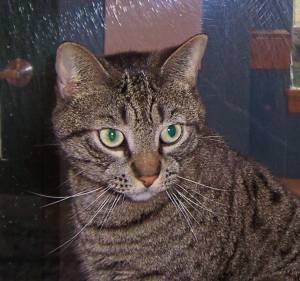

In [5]:
# Some imports to help us out
import PIL
from IPython.display import Image, display


# A utility function to help us quickly display various files
# Can be used within a loop.
def show(filename):
    display(Image(filename))
    

def size(filename):
    return PIL.Image.open(filename).size


def info(filename):
    print('Image Name: "{}"'.format(filename))
    print('Image Size (W x H): {}'.format(size(filename)))
    show(filename)


# Try different image IDs (0 - 12499)!
info('PetImages/Cat/1.jpg')

## Creating our training and test data sets

Since we have 12,500 images of either cats or dogs, we have to determine how large our training and test data sets should be. A nice round number would be 500 test images per animal with 12,000 images for training.

Let's do this with Python. First, let's create the directories we'll need (this can be done in Python, but it's much easier and convenient to do via the terminal).

In [0]:
!mkdir train test

Now let's define some utility functions that will allow us to easily perform the random selections, renaming, and moving of the filenames.

In [0]:
import os
import shutil
import random


ROOT_DIR = os.getcwd()
IMAGES_DIR = os.path.join(ROOT_DIR, 'PetImages')
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')


# Number of images (per image class!) to select for testing
NUM_TEST_IMAGES_PER_CLASS = 500


def rename_files(filenames, indices, destination_dir):
    # rename filenames
    image_class = None
    for idx, index in enumerate(indices):
        old_fname = filenames[index]
        if image_class is None:
            image_class = os.path.basename(os.path.dirname(old_fname)).lower()

        new_fname = os.path.join(destination_dir,\
                                 '{}_{}.jpg'.format(image_class, idx))
        shutil.copyfile(old_fname, new_fname)


# We use `random.sample` since we want unique & random selections
def create_datasets(filenames):
    indices = list(range(0, len(filenames)))
    indices_to_test = random.sample(indices, k=NUM_TEST_IMAGES_PER_CLASS)
    indices_to_train = [idx for idx in indices if idx not in indices_to_test]

    rename_files(filenames, indices_to_test, TEST_DIR)
    rename_files(filenames, indices_to_train, TRAIN_DIR)

In [0]:
# Load the image filenames for a given image class
def get_images(directory, image_class):
    images_classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    if image_class not in images_classes:
        print('Image class "{}" not found'.format(image_class))
        return
    files = [f for f in os.listdir(os.path.join(IMAGES_DIR, image_class)) if f.endswith('jpg')]
    images = list(sorted(files, key=lambda x: int(x.split('.')[0])))
    image_filenames = [os.path.join(directory, image_class, img) for img in images]
    return image_filenames


cats = get_images(IMAGES_DIR, 'Cat')
dogs = get_images(IMAGES_DIR, 'Dog')


# Now create the datasets:
create_datasets(cats)
create_datasets(dogs)

Finally, let's verify that we've successfully completed the operation:

In [9]:
!ls -l test/cat* | egrep -c '^-'

500


In [10]:
!ls -l train/cat* | egrep -c '^-'

12000


In [11]:
!ls -l test/dog* | egrep -c '^-'

500


In [12]:
!ls -l train/dog* | egrep -c '^-'

12000


## Convolutional Neural Networks (CNNs)

![alt text](https://miro.medium.com/max/700/1*R-ItxBW2SWarITBKe7HZuA.gif)

Compared to simple neural networks that utilize matrix multiplication in one of their layers, a CNN performs a convolution - or specialized linear operation.

This allows us to create **feature maps**. Initially, we have a small number of filters which perform rudimentary feature detection. But, as we delve deeper into the CNN, we yield more (but often smaller) filters that can detect increasingly complex features.

![alt text](https://miro.medium.com/max/700/1*yZQjaMKHjm1HzDF4t4juzg.png)

Feature detection is determined by scanning the input with a filter of fixed size, and applying a linear set of matrix operations to extract a feature map.

![alt text](https://miro.medium.com/max/678/1*-OM6jQTMNACDX2vAh_lvMQ.png)

![alt text](https://miro.medium.com/max/700/1*h1S9FFDHmmj5yY_Y3uMcgw.gif)

# Approach

Each picture is represented as a 3D array. To simplify things, we need to do two things:

![RGB Doge](https://cdn-images-1.medium.com/max/1600/1*9ng9AxixrDUGvVfKA7dypg.png)

1. Resize all the training data to 50x50 pixels. An example of a 64x64 image is shown above.

2. Convert all the pictures to greyscale. This gives us several advantages: 

> *Converting to gray scale is not necessary for image processing, but is usually done for a few reasons:*
>
> **Simplicity** - Many image processing operations work on a plane of image data (e.g., a single color channel) at a time. So if you have an RGBA image you might need to apply the operation on each of the four image planes and then combine the results. Gray scale images only contain one image plane (containing the gray scale intensity values).
>
>**Data reduction** - Suppose you have a RGBA image (red-green-blue-alpha). If you converted this image to gray scale you would only need to process 1/4 of the data compared to the color image. For many image processing applications, especially video processing (e.g., real-time object tracking), this data reduction allows the algorithm to run in a reasonable amount of time.
>
>However, it's important to understand that while there are many advantages of converting to gray scale, it is not always desirable. When you convert to gray scale you not only reduce the quantity of image data, but you also lose information (e.g., color information). For many image processing applications color is very important, and converting to gray scale can worsen results.
>
**To summarize**: If converting to gray scale still yields reasonable results for whatever application you're working on, it is probably desirable, especially due to the likely reduction in processing time. However it comes at the cost of throwing away data (color data) that may be very helpful or required for many image processing applications.

See: https://stackoverflow.com/questions/20473352/is-conversion-to-gray-scale-a-necessary-step-in-image-preprocessing

In [13]:
# Setting up
import numpy as np
from skimage import io, transform
import tensorflow as tf

import matplotlib.pyplot as plt


import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


IMG_SIZE = 50
LEARNING_RATE = 1e-3
MODEL_NAME = 'cats-and-dogs-CNN'

W0808 11:27:35.940321 139652725843840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0808 11:27:35.941784 139652725843840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0808 11:27:35.958444 139652725843840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0808 11:27:35.965930 139652725843840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0808 11:27:35.980342 139652725843840 deprecation_wrapper.py:119] From /usr/local/lib/

In [0]:
# Let's create a function that encodes the labels of the training images
def create_label(image_name):
    """ Create an one-hot encoded vector from image name """
    word_label = image_name.split('.')[-3]
    if word_label == 'cat':
        return np.array([1,0])
    elif word_label == 'dog':
        return np.array([0,1])
    

# And, since we want to resize each image to 50 x 50 pixels
# and convert to greyscale
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        path = os.path.join(TRAIN_DIR, img)
        img_data = io.imread(path, as_grey=True)  # to greyscale
        img_data = transform.resize(img_data, (IMG_SIZE, IMG_SIZE))  # resize
        training_data.append([np.array(img_data), create_label(img)])  # collect
    shuffle(training_data)  # randomize
    np.save('train_data.npy', training_data)  # save
    return training_data

In [0]:
# Similarly for the test data:
def create_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img_data = io.imread(path, as_grey=True)  # greyscale
        img_data = transform.resize(img_data, (IMG_SIZE, IMG_SIZE))  # resize
        testing_data.append([np.array(img_data), img_num])  # collect

    shuffle(testing_data)  # randomize
    np.save('test_data.npy', testing_data)  # save
    return testing_data

In [0]:
# read, resize, and convert to greyscale all the images (if necessary)

# first, a convenience function to check for file existence:
def file_exists(filepath):
    if os.path.isfile(filepath) and os.path.exists(filepath):
        return True
    return False


# now load, or generate in the current directory
if file_exists('train_data.npy'):
    train_data = np.load('train_data.npy')
else:
    # If dataset is not created:
    train_data = create_train_data()


# similar to the above
if file_exists('test_data.npy'):
    test_data = np.load('test_data.npy')
else:
    # If dataset is not created:
    test_data = create_test_data()

Now, let’s split the data. 24,500 images for training and 500 for testing. We also need to reshape the data appropriately for TensorFlow:

In [0]:
train = train_data[:-500]  # skip the last 500
test = train_data[-500:]  # use the last 500 for training

# -1 means that 'the new shape should be compatible with the original shape'
# See: https://stackoverflow.com/a/42510505/866930
# This means to reshape into 50x50 pixel arrays, which have 1 dimension
# That dimension is greyscale which goes from 0 to 255
X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

# Convolutional Neural Networks

A convolutional neural network consists of several layers. 

![CNN](http://white.stanford.edu/teach/images/d/df/Mylenet.png)

These layers can be of three types:

1. **Convolutional**: Convolutional layers consist of a rectangular grid of neurons. It requires that the previous layer also be a rectangular grid of neurons. Each neuron takes inputs from a rectangular section of the previous layer; the weights for this rectangular section are the same for each neuron in the convolutional layer. Thus, the convolutional layer is just an image convolution of the previous layer, where the weights specify the convolution filter. In addition, there may be several grids in each convolutional layer; each grid takes inputs from all the grids in the previous layer, using potentially different filters.

2. **Max-Pooling**: After each convolutional layer, there may be a pooling layer. The pooling layer takes small rectangular blocks from the convolutional layer and subsamples it to produce a single output from that block. There are several ways to do this pooling, such as taking the average or the maximum, or a learned linear combination of the neurons in the block. Our pooling layers will always be max-pooling layers; that is, they take the maximum of the block they are pooling.

3. **Fully-Connected**: Finally, after several convolutional and max pooling layers, the high-level reasoning in the neural network is done via fully connected layers. A fully connected layer takes all neurons in the previous layer (be it fully connected, pooling, or convolutional) and connects it to every single neuron it has. Fully connected layers are not spatially located anymore (you can visualize them as one-dimensional), so there can be no convolutional layers after a fully connected layer.

Note that we are not really constrained to two-dimensional convolutional neural networks. We can in the exact same way build one- or three- dimensional convolutional neural networks; our filters will just become appropriately dimensioned, and our pooling layers will change dimension as well. We may, for instance, want to use one-dimensional convolutional nets on audio or three-dimensional nets on MRI data.


### Reference:
1. http://andrew.gibiansky.com/blog/machine-learning/convolutional-neural-networks/

Now we build our Convolutional Network which can be thought of small sliding lenses (e.g. 10 x 10) which are "activated" when placed above some feature that is "familiar" to them. Since we're trying to distinguish between cats and dogs, this requires more features and hences involves looking at portions of the image rather than pixels alone. Hence, a convolutional network can examine and learn from larger portions of an image rather than single pixels.

So, in our case we'll be using `tflearn` to build the Convolutional Neural Network (CNN). In addition to hidden layers, we'll also add a dropout layer.

In [0]:
tf.reset_default_graph()

# create an initial input layer bases on the shape of the resized images
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

# now add the input layer to a convolutional layer with 32 filters
# and a stride of 5 using an ReLU activation
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5) # create a pool of 5 kernels

# similar to above, but with more filters
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# now add a fully connected layer
convnet = fully_connected(convnet, 1024, activation='relu')

# now add a dropout layer
# As other regularization techniques the use of dropout also make the training 
# loss error a little worse. But that's the idea, basically we want to trade 
# training performance for more generalization. Remember that's more capacity 
# you add on your model (More layers, or more neurons) more prone to over-fit 
# it becomes.
#
# adding dropout after the max-pooling layers, creates image noise augmentation
# which gives the NN more generality
convnet = dropout(convnet, 0.8)

# add another fully connected layer of 2 neurons - these will be our
# outputs which will hold the probabilities of an image being a cat or dog.
convnet = fully_connected(convnet, 2, activation='softmax')

# We use Adam as optimizer with learning rate set to 0.001. 
# Our loss function is categorical cross entropy. Finally, we train our 
# Deep Neural Net for 10 epochs.
convnet = regression(convnet, 
                     optimizer='adam', 
                     learning_rate=LR, 
                     loss='categorical_crossentropy', 
                     name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.30335 | time: 5.135s
| Adam | epoch: 010 | loss: 0.30335 - acc: 0.8761 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.29966 | time: 6.149s
| Adam | epoch: 010 | loss: 0.29966 - acc: 0.8791 | val_loss: 0.56914 - val_acc: 0.7700 -- iter: 24500/24500
--


# Building a bigger model (more layers)

In [0]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')

convnet = regression(convnet, 
                     optimizer='adam', 
                     learning_rate=LR, 
                     loss='categorical_crossentropy', 
                     name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log', tensorboard_verbose=0)
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=10, 
          validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.27014 | time: 6.742s
| Adam | epoch: 010 | loss: 0.27014 - acc: 0.8859 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.26853 | time: 7.760s
| Adam | epoch: 010 | loss: 0.26853 - acc: 0.8848 | val_loss: 0.60048 - val_acc: 0.7780 -- iter: 24500/24500
--


Using the same model, but by adding more layers we've improved the performance. Our model has much more parameters and can learn more complex functions. One proof of that is the validation accuracy that is around 0.8. Let’s take our model for a spin!

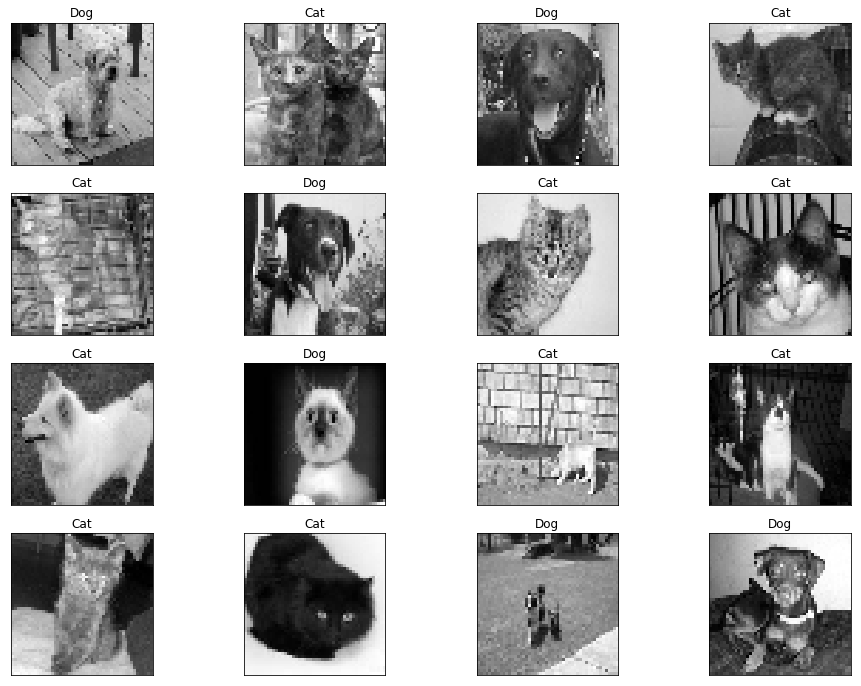

In [0]:
# look at some of the test data images:
fig=plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

# Activity 1: Modify the number of layers in your CNN - how does it affect the result?

# Activity 2: How does the activation function affect the performance of the CNN?

Hint: Keras supports the following activation functions: `softplus`, `softsign`, `softsign`, `relu`, `tanh`, `sigmoid`, `hard_sigmoid`, and `linear`. See: https://keras.io/activations/

# Reference
1. https://medium.com/@curiousily/tensorflow-for-hackers-part-iii-convolutional-neural-networks-c077618e590b
2. https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/dropout_layer.html
3. https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
4. https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f
5. https://www.datasciencecentral.com/profiles/blogs/dogs-vs-cats-image-classification-with-deep-learning-using
    